In [29]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

In [30]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [31]:
Medicine_finance = pd.read_excel('./data/dongboo/제약_TOTAL_재무사항.xlsx')
Medicine_nonfinance = pd.read_excel('./data/dongboo/비재무/제약_비재무_TOTAL_최종.xlsx')

Medicine_validation_finance = pd.read_excel('./data/dongboo/제약_validation_재무사항.xlsx')
Medicine_val_nonfinance = pd.read_excel('./data/dongboo/비재무validation/validation_비재무_제약_total_최종.xlsx')

In [32]:
Medicine_stock = pd.read_excel('./data/dongboo/제약_주가_total_krx.xlsx')
Medicine_validation_stock = pd.read_excel('./data/dongboo/제약_validation_주가.xls')

In [33]:
Medicine_info = pd.merge(Medicine_finance, Medicine_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])
Medicine = pd.merge(Medicine_info,Medicine_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])

Medicine_var_info = pd.merge(Medicine_validation_finance, Medicine_val_nonfinance, how = 'left', on = ['회사명','거래소코드','회계년도'])
Medicine_var = pd.merge(Medicine_var_info,Medicine_validation_stock, how = 'left', on = ['회사명','거래소코드','회계년도'])

# 회사별로 분리

In [34]:
greencross = Medicine[Medicine['회사명'] == '(주)녹십자']
daewoong = Medicine[Medicine['회사명'] == '(주)대웅제약']
yoohan = Medicine[Medicine['회사명'] == '(주)유한양행']
hanmi = Medicine[Medicine['회사명'] == '한미약품(주)']

donga = Medicine_var[Medicine_var['회사명'] == '동아에스티(주)']
boogwang = Medicine_var[Medicine_var['회사명'] == '부광약품(주)']
ilyang = Medicine_var[Medicine_var['회사명'] == '일양약품(주)']
jw = Medicine_var[Medicine_var['회사명'] == '제이더블유중외제약(주)']

In [35]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [36]:
classify(greencross)
classify(daewoong)
classify(yoohan)
classify(hanmi)
#---------- validation ---------------------
classify(donga)
classify(boogwang)
classify(ilyang)
classify(jw)

,회사명,거래소코드,회계년도,자산(*),자본(*),* 수권주식수,*주당 액면가액,* 발행한 주식총수(*),보통주,우선주,지배기업주주지분(*),자본금(*),보통주자본금,우선주자본금,신종자본증권,자본잉여금(*),주식발행초과금,배당건설이자,주식매입선택권,감자차익,보험차익,합병차익,자산수증이익,채무면제이익,자기주식처분이익,전환권대가,신주인수권대가,교환권대가,전환권재매입이익,기타자본잉여금,재평가적립금(2001년 이전),기타자본(*),자기주식,자기주식처분손실,주식할인발행차금,주식매입선택권.1,감자차손,파생상품평가이익,파생상품평가손실,전환권재매입손실,기타,기타포괄손익누계액(*),금융자산평가손익,매도가능금융자산평가손익,관계기업 등 기타포괄손익,환산 관련 외환차이 적립금(환율변동차이),해외사업장순투자위험회피 적립금,확정급여제도의 보험수리적 손익 적립금,확정급여제도의 재측정요소,현금흐름위험회피 적립금,주식기준보상 적립금,재평가잉여금,기타.1,이익잉여금(결손금)(*),* (지배)당기순손익,이익준비금,재무구조개선적립금,기업합리화적립금,기타법정적립금,재평가손익,보험수리적손익,기타이익잉여금,미처분이익잉여금(결손금),*전기이월미처분이익잉여금(결손금),비지배주주지분,* (비지배)당기순손익,*비지배주주지분초과손실액,부채(*),* (정상)영업손익(보고서기재)(3개월),* (정상)영업손익(계산수치)(3개월),기타이익(*)(3개월),이자수익(3개월),배당금수익(3개월),외환거래이익(*)(3개월),외환차익(3개월),외환환산이익(3개월),기타외화거래이익(3개월),보험차익(3개월),퇴직연금운용이익(3개월),전기오류수정이익(3개월),기타(3개월),기타손실(*)(3개월),이자비용(3개월),외환거래손실(*)(3개월),외환차손(3개월),외화환산손실(3개월),기타외환거래손실(3개월),법인세추납액(3개월),퇴직연금운용손실(3개월),전기오류수정손실(3개월),기타(3개월).1,법인세비용차감전순이익(손실)(3개월),법인세비용(3개월),종속회사 매수일전 순손익(3개월),처분된 종속회사 순손익(3개월),계속영업이익(손실)(3개월),중단영업이익(손실)(3개월),*중단영업손익 법인세효과(3개월),당기순이익(손실)(3개월),기타포괄손익(*)(3개월),금융자산평가손익(3개월),매도가능금융자산평가손익(3개월),관계기업 등 기타포괄손익(3개월),환산 관련 외환차이(환율변동차이)(3개월),해외사업장순투자위험회피(3개월),현금흐름위험회피 적립금(3개월),확정급여제도의 보험수리적손익(3개월),확정급여제도의 재측정요소(3개월),주식기준보상 적립금(3개월),재평가손익(3개월),기타(3개월).2,기타포괄손익관련 법인세(3개월),총포괄손익(3개월),*(당기순손익 귀속)지배기업주주지분(3개월),*계속영업손익(3개월),*중단영업손익(3개월),*(당기순손익 귀속)비지배주주지분(3개월),*계속영업손익(3개월).1,*중단영업손익(3개월).1,*(총포괄손익 귀속)지배기업주주지분(3개월),*(총포괄손익 귀속)비지배주주지분(3개월),*주당계속영업이익(3개월),*주당순손익(3개월),*희석주당계속영업이익(3개월),*희석주당순손익(3개월),*(지배기업주주지분)주당계속영업이익(3개월),*(지배기업주주지분)주당순손익(3개월),*(지배기업주주지분)희석주당계속영업이익(3개월),*(지배기업주주지분)희석주당순손익(3개월),* 성격별 비용계정(*)(3개월),제품과 재공품의 변동(3개월),기업이 수행한 용역으로서 자본화되어 있는 부분(3개월),원재료와 저장품(소모품)의 사용액(3개월),상품의 판매(3개월),기타원가(3개월),종업원 급여비용(3개월),감가상각비와 기타상각비 및 손상차손(3개월),세금과공과(3개월),대손상각비(3개월),물류비(운송보관)(3개월),광고 및 판매촉진비(3개월),임차료 및 리스료(3개월),경상연구개발비(3개월),기타비용(3개월),기말자본금(*),기초자본금,유상증자(감자),무상증자(감자),주식매수선택권,전환사채,신주인수권부사채,주식배당,합병분할(영업양수도 등)로 인한 변동,회계정책변경누적효과,오류수정 등,연결범위의 변동,외화환산차이,기타.2,기말신종자본증권(*),기초신종자본증권,신종자본증권의 발행,기타.3,기말자본잉여금(*),기초자본잉여금,유상증자(감자).1,무상증자(감자).1,주식발행초과금.1,주식매수선택권.1,감자차손익,보험차익.1,자기주식처분손익,전환권대가(전환사채),신주인수권대가(신주인수권부사채),교환권대가(교환사채),전환권재매입손익,결손금처리,지분법자본잉여금,합병분할(영업양수도 등)로 인한 변동.1,회계정책변경누적효과.1,오류수정 등.1,연결범위의 변동.1,외화환산차이.1,기타.4,기말기타자본(*),기초기타자본,자기주식.1,자기주식처분손실.1,주식할인발행차금.1,주식매입선택권.2,파생상품평가이익.1,파생상품평가손실.1,출자전환채무,신주청약증거금,감자차손익.1,전환권재매입손익.1,지분법자본조정,합병분할(영업양수도 등)로 인한 변동.2,회계정책변경누적효과.2,오류수정 등.2,연결범위의 변동.2,외화환산차이.2,기타.5,기말기타포괄손익누계액(*),기초기타포괄손익누계액,금융자산평가손익.1,매도가능금융자산 평가손익,관계기업 등 기타포괄손익.1,환산 관련 외환차이 적립금(환율변동차이).1,해외사업장순투자위험회피 적립금.1,확정급여제도의 보험수리적 손익 적립금.1,확정급여제도의 재측정요소.1,현금흐름위험회피 적립금.1,주식기준보상 적립금.1,재평가잉여금.1,합병분할(영업양수도 등)로 인한 변동.3,회계정책변경누적효과.3,오류수정 등.3,연결범위의 변동.3,외화환산차이.3,기타.6,기말이익잉여금(결손금)(*),처분후 이익잉여금(결손금)(*),수정후 이익잉여금(결손금)(*),기초이익잉여금(결손금),회계정책변경누적효과.4,전기오류수정손익,기타.7,(연차배당),(신종자본증권 분배금),주식할인발행차금의 상각,자기주식처분손실의 상각,결손금처리.1,기타이익잉여금처분액,(중간배당),확정급여제도의 재측정요소.2,기타포괄손익,당기순이익(총포괄손익),보험수리적손익.1,재평가손익.1,지분법이익잉여금,합병분할(영업양수도 등)로 인한 변동.4,연결범위의 변동.4,외화환산차이.4,기타.8,기말비지배주주지분(*),처분후 비지배주주지분(*),수정후 비지배주주지분(*),기초 비지배주주지분,회계정책변경누적효과.5,전기오류수정손익.1,기타.9,(종속회사의 배당금),기타.10,(중간배당).1,당기순이익(총포괄손익).1,재평가잉여금.2,금융자산평가손익.2,매도가능금융자산 평가손익.1,관계기업 등 지분법평가손익,환산 관련 외환차이 적립금(환율변동차이).2,해외사업장순투자위험회피 적립금.2,확정급여제도의 보험수리적 손익 적립금.2,확정급여제도의 재측정요소.3,현금흐름위험회피 적립금.2,주식기준보상 적립금.2,기타포괄손익누계액,합병분할로 인한 변동,연결범위의 변동.5,외화환산차이.5,기타.11,영업활동으로 인한 현금흐름(간접법)(*),*(직접법)총현금유입(*),재화의 판매와 용역제공에 따른 현금유입,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유입",이자수취액,배당금수취액,법인세환급,기타현금유입액,*(직접법)총현금유출(*),종업원과 관련하여 직·간접으로 발생하는 현금유출,"수입보험료, 보험금, 연금 및 기타 급부금관련 현금유출",이자비용유출액,배당금지급액,법인세납부,단기매매목적으로 보유하는 계약에서 발생하는 현금유출,기타현금유출액,당기순손익,법인세비용차감전순손익,현금 유출이 없는 비용 등 가산(*),전기오류수정손익.2,비지배주주지분순손익,보험수리적손실,기타.12,(현금 유입이 없는 수익 등 차감)(*),전기오류수정손익.3,비지배주주지분순손익.1,보험수리적이익,기타.13,영업활동으로 인한 자산부채 변동(운전자본 변동)(*),자산의 감소(증가)(*),부채의 증가(감소)(*),정부보조금 등의 변동,기타 운전자본의 변동,*영업에서 창출된 현금흐름,이자수입,이자지급(-),배당금수입,배당금지급(-),법인세환입,법인세납부(-),중단영업관련 현금흐름,투자활동으로 인한 현금흐름(*),투자활동으로 인한 현금유입액(*),정부보조금 등의 변동.1,종속기업 및 기타사업의 지배력 관련한 현금흐름,합병분할(양수도등)으로 인한 현금유입액,기타투자활동으로 인한 현금유입액,(투자활동으로 인한 현금유출액)(*),정부보조금 등의 변동.2,종속기업 및 기타사업의 지배력 관련한 현금흐름.1,합병분

In [37]:
greencross = greencross.iloc[:-1,:]
daewoong = daewoong.iloc[:-1,:]
yoohan = yoohan.iloc[:-1,:]
hanmi = hanmi.iloc[:-1,:]
#---------- validation ---------------------
donga = donga.iloc[:-1,:]
boogwang = boogwang.iloc[:-1,:]
ilyang = ilyang.iloc[:-1,:]
jw = jw.iloc[:-1,:]

# 산업별 변수 <3개월 후 종가>와의 상관관계 분석

In [38]:
greencross_corr = greencross.corr(method = 'pearson')
df_greencross = pd.DataFrame(greencross_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_greencross.columns = ['지표','3개월후종가']

daewoong_corr = daewoong.corr(method = 'pearson')
df_daewoong = pd.DataFrame(daewoong_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_daewoong.columns = ['지표','3개월후종가']

yoohan_corr = yoohan.corr(method = 'pearson')
df_yoohan = pd.DataFrame(yoohan_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_yoohan.columns = ['지표','3개월후종가']

hanmi_corr = hanmi.corr(method = 'pearson')
df_hanmi = pd.DataFrame(hanmi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hanmi.columns = ['지표','3개월후종가']

In [39]:
pd.concat([df_greencross.reset_index(drop = True), df_daewoong.reset_index(drop = True),
           df_yoohan.reset_index(drop = True), df_hanmi.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,해외사업장순투자위험회피 적립금,0.739851,최저가,0.877201,종가,0.711440,기초자본잉여금,0.891570
2,(종속회사의 배당금),0.723600,종가,0.871456,최고가,0.710244,최고가,0.889548
3,부채(*),0.720416,정규+무기계약_기말인원(명),0.862109,최저가,0.705145,종가,0.874019
4,최고가,0.719608,최고가,0.856219,부채(*),0.658813,최저가,0.851419
5,종가,0.719570,정규+무기계약_기말인원(여)(명),0.791177,자기주식수(주),0.642599,기초자본금,0.821295
6,최저가,0.703807,기초 현금및현금성자산,0.769930,(연차배당),0.603166,자산(*),0.801415
7,기초 비지배주주지분,0.702386,기말이익잉여금(결손금)(*),0.750513,거래대금,0.587659,비지배주주지분,0.797780
8,수정후 비지배주주지분(*),0.702386,이익잉여금(결손금)(*),0.750513,법인세비용차감전순이익(손실)(3개월),0.584581,기말비지배주주지분(*),0.797780
9,처분후 비지배주주지분(*),0.700800,지배기업주주지분(*),0.730665,당기순이익(손실)(3개월),0.554640,부채(*),0.782669


In [40]:
list_corr = []
order = 20 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_greencross.index[:order])):
    list_corr.append(df_greencross.index[:order][i])
    list_corr.append(df_daewoong.index[:order][i])
    list_corr.append(df_yoohan.index[:order][i])
    list_corr.append(df_hanmi.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [41]:
var = []
for i in range(len(variable)):
    var.append(df_greencross[df_greencross.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [42]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]

# 3개월후 종가 및 수익률 상승하락 drop 시킴

In [43]:
corr = corr[corr['var'] != '3개월후종가'].reset_index(drop = True)
corr = corr[corr['var'] != '수익률상승하락'].reset_index(drop = True)
corr

,var_index,var,number
0,1,자산(*),4
1,391,최고가,4
2,392,최저가,4
3,393,종가,4
4,65,부채(*),4
5,245,기초 비지배주주지분,3
6,51,이익잉여금(결손금)(*),3
7,218,기말이익잉여금(결손금)(*),3
8,220,수정후 이익잉여금(결손금)(*),2
9,2,자본(*),2


In [44]:
deep_greencross = greencross[corr['var'][:20]]
deep_yoohan = yoohan[corr['var'][:20]]
deep_daewoong = daewoong[corr['var'][:20]]
deep_hanmi = hanmi[corr['var'][:20]]

deep_greencross['수익률상승하락'] = greencross['수익률상승하락']
deep_yoohan['수익률상승하락'] = yoohan['수익률상승하락']
deep_daewoong['수익률상승하락'] = daewoong['수익률상승하락']
deep_hanmi['수익률상승하락'] = hanmi['수익률상승하락']



deep_donga = donga[corr['var'][0:20]]
deep_boogwang = boogwang[corr['var'][0:20]]
deep_ilyang = ilyang[corr['var'][0:20]]
deep_jw = jw[corr['var'][0:20]]

deep_donga['수익률상승하락'] = donga['수익률상승하락']
deep_boogwang['수익률상승하락'] = boogwang['수익률상승하락']
deep_ilyang['수익률상승하락'] = ilyang['수익률상승하락']
deep_jw['수익률상승하락'] = jw['수익률상승하락']

In [45]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_greencross = StandardScaler()
scale_greencross = pd.DataFrame(scaler_greencross.fit_transform(deep_greencross.iloc[:,:-1]))

scaler_yoohan = StandardScaler()
scale_yoohan = pd.DataFrame(scaler_yoohan.fit_transform(deep_yoohan.iloc[:,:-1]))

scaler_daewoong = StandardScaler()
scale_daewoong = pd.DataFrame(scaler_daewoong.fit_transform(deep_daewoong.iloc[:,:-1]))

scaler_hanmi = StandardScaler()
scale_hanmi = pd.DataFrame(scaler_hanmi.fit_transform(deep_hanmi.iloc[:,:-1]))




scaler_donga = StandardScaler()
scale_donga = pd.DataFrame(scaler_donga.fit_transform(deep_donga.iloc[:,:-1]))

scaler_boogwang = StandardScaler()
scale_boogwang = pd.DataFrame(scaler_boogwang.fit_transform(deep_boogwang.iloc[:,:-1]))

scaler_ilyang = StandardScaler()
scale_ilyang = pd.DataFrame(scaler_ilyang.fit_transform(deep_ilyang.iloc[:,:-1]))

scaler_jw = StandardScaler()
scale_jw = pd.DataFrame(scaler_jw.fit_transform(deep_jw.iloc[:,:-1]))
# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [48]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_Medicine = pd.concat([deep_greencross,deep_yoohan,deep_daewoong,deep_hanmi], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_Medicine = pd.concat([scale_greencross,scale_yoohan,scale_daewoong,scale_hanmi], ignore_index=True)



# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_Medicine_validation = pd.concat([deep_donga,deep_boogwang,deep_ilyang,deep_jw], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_Medicine_validation = pd.concat([scale_donga,scale_boogwang,scale_ilyang,scale_jw], ignore_index=True)


In [24]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

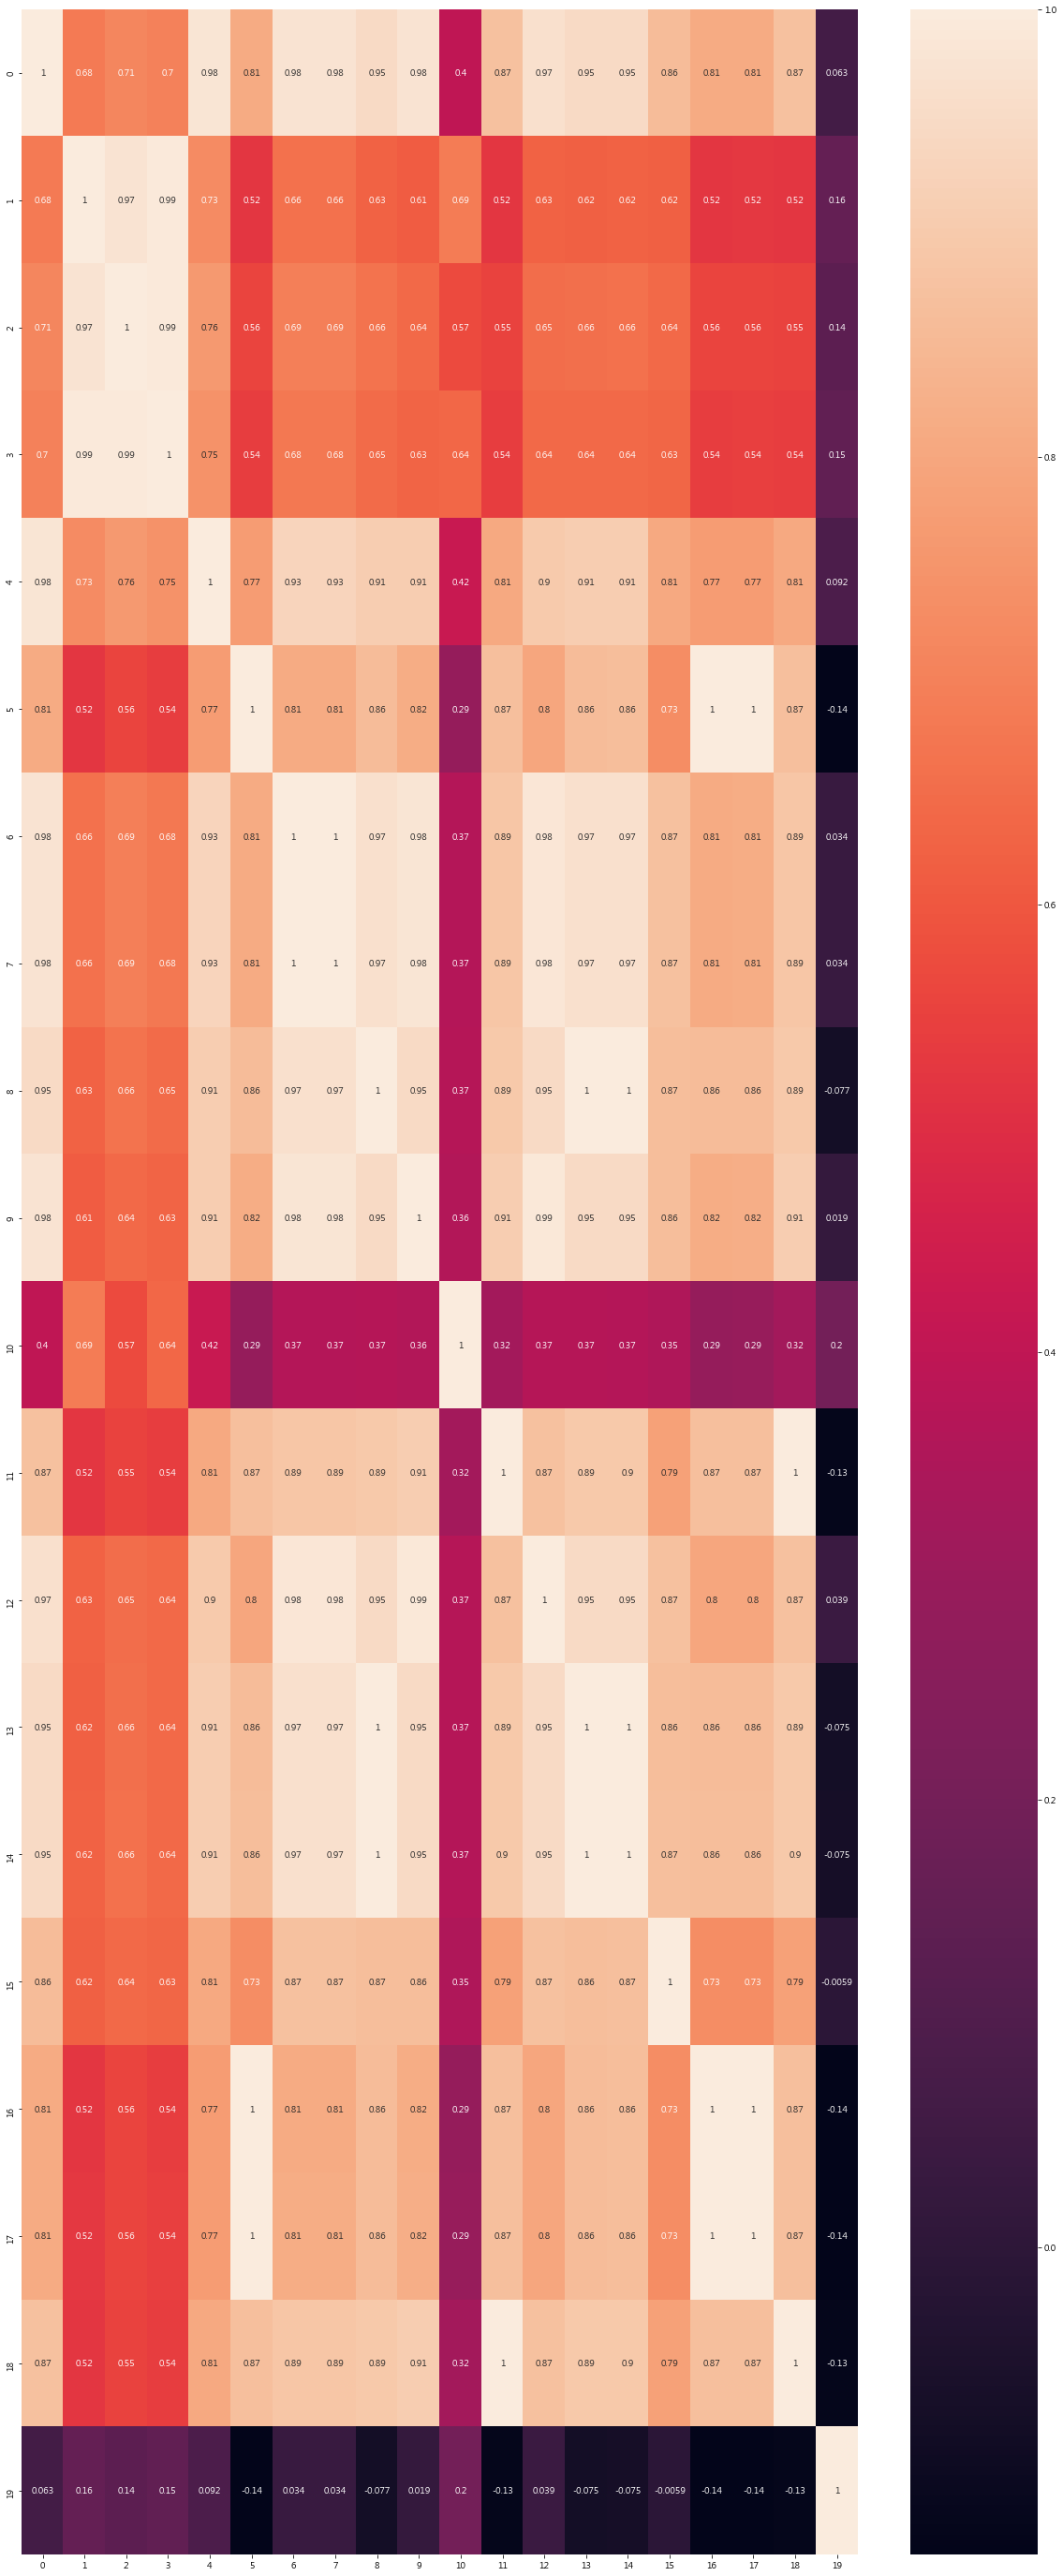

In [25]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_Medicine.corr(), annot = True)
# plt.savefig('tmp.png')

In [46]:
def xavier_init(n_inputs, n_outputs, uniform=True):
    if uniform:
        # 6 was used in the paper.
        init_range = tf.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limints as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = tf.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

In [49]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_Medicine
y_data = deep_Medicine.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.01




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

# <span style="color:red"> 가치주로 validation

In [50]:
# Launch graph

validation_number = 20
#init_state = lstm_cell.zero_state(128, tf.float32)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(20001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))    

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 0.766440212726593 	 Acc : 55.000001192092896
Step : 1 	 Cost : 0.8444660305976868 	 Acc : 60.00000238418579
Step : 2 	 Cost : 0.8527942895889282 	 Acc : 60.00000238418579
Step : 3 	 Cost : 0.8387772440910339 	 Acc : 60.00000238418579
Step : 4 	 Cost : 0.7974591851234436 	 Acc : 60.00000238418579
Step : 5 	 Cost : 0.757276713848114 	 Acc : 60.00000238418579
Step : 6 	 Cost : 0.7243295907974243 	 Acc : 60.00000238418579
Step : 7 	 Cost : 0.7512214183807373 	 Acc : 60.00000238418579
Step : 8 	 Cost : 0.75638747215271 	 Acc : 64.99999761581421
Step : 9 	 Cost : 0.7143175601959229 	 Acc : 64.99999761581421
Step : 200 	 Cost : 0.6991862058639526 	 Acc : 44.999998807907104
Step : 400 	 Cost : 0.6662810444831848 	 Acc : 44.999998807907104
Step : 600 	 Cost : 0.6622708439826965 	 Acc : 44.999998807907104
Step : 800 	 Cost : 0.7163010239601135 	 Acc : 44.999998807907104
Step : 1000 	 Cost : 0.57198566198349 	 Acc : 44.999998807907104
Step : 1200 	 Cost : 0.6188904047012329 	 Ac

In [28]:
print('모델 정확도: ', a1 * 100 , '%')

모델 정확도:  55.000001192092896 %


In [29]:

# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c1.ravel())})

,real,predict
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,0.0,0.0
8,1.0,0.0
9,0.0,0.0


In [30]:
h1

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

# <span style="color:red"> 비 가치주로 validation

In [51]:
# Launch graph

validation_number = 20


# samsungelectric / lgelectric / sds / lgdisplay

x_val_data = scale_Medicine_validation
y_val_data = deep_Medicine_validation.iloc[:,[-1]]

# x_val_data = scale_IT_validation
# y_val_data = deep_IT_validation.iloc[:,[-1]]

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(20001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_val_data.iloc[:,:], Y: y_val_data.iloc[:,:], keep_prob: 1.0})
            print("Step : {} \t Cost : {} \t Acc : {}".format(step, cost_val, a*100))     

Step : 0 	 Cost : 1.4118753671646118 	 Acc : 45.83333432674408
Step : 1 	 Cost : 1.4442098140716553 	 Acc : 45.83333432674408
Step : 2 	 Cost : 1.3643041849136353 	 Acc : 45.83333432674408
Step : 3 	 Cost : 1.0885059833526611 	 Acc : 45.83333432674408
Step : 4 	 Cost : 1.0060369968414307 	 Acc : 47.22222089767456
Step : 5 	 Cost : 0.9683588147163391 	 Acc : 47.22222089767456
Step : 6 	 Cost : 0.941891074180603 	 Acc : 47.22222089767456
Step : 7 	 Cost : 0.9531666040420532 	 Acc : 45.83333432674408
Step : 8 	 Cost : 0.8289052844047546 	 Acc : 45.83333432674408
Step : 9 	 Cost : 0.8509221076965332 	 Acc : 47.22222089767456
Step : 200 	 Cost : 0.6890160441398621 	 Acc : 55.55555820465088
Step : 400 	 Cost : 0.6923816204071045 	 Acc : 63.88888955116272
Step : 600 	 Cost : 0.6781204342842102 	 Acc : 62.5
Step : 800 	 Cost : 0.6749616861343384 	 Acc : 62.5
Step : 1000 	 Cost : 0.6531680226325989 	 Acc : 63.88888955116272
Step : 1200 	 Cost : 0.5823045372962952 	 Acc : 65.27777910232544
Step 

In [52]:
'''
# 테스트 셋 20개 일때
# 에폭 : 5001 번 일때 정확도 45%
# 에폭 : 7001 번 일때 정확도 65%
# 에폭 : 9001 번 일때 정확도 60%
# 에폭 : 12000 번 일때 정확도 70%
# 에폭 : 15000 번 일때 정확도 60%
# 에폭 : 18000 번 일때 정확도 60%
# 에폭 : 21000 번 일때 정확도 60%
'''
print('모델 정확도: ', a * 100 , '%')

모델 정확도:  45.83333432674408 %


In [53]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_val_data.iloc[:,:].values.ravel()),'predict': list(c.ravel())})

,real,predict
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0
5,1.0,0.0
6,1.0,0.0
7,0.0,0.0
8,0.0,0.0
9,1.0,0.0
